# Libraries

In [1]:
#!pip install imbalanced-learn

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, f1_score, recall_score, precision_score
import tensorflow as tf
from tensorflow.keras import layers, models

from tensorflow.keras.layers import Input, Dense

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from tensorflow.keras.utils import plot_model

import seaborn as sns
from pylab import rcParams
#from matplotlib import pyplot as plt
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

<h1 style="color:blue;">Load Dataset</h1>

## 1. Load the DS

In [3]:
df = pd.read_csv("Kaggle-credit-card-fraud-detection-US_13Jul24/creditcard.csv")  # Imbalanced DS
#df = pd.read_csv("Kaggle-credit-card-fraud-detection_18Sep23/creditcard_2023.csv") # Balanced DS


In [4]:
print(df.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

<h1 style="color:blue;">Data Exploration</h1>

In [5]:
df.shape

(284807, 31)

In [6]:
# Check Null
df.isnull().values.any()

False

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [8]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [9]:
#Lets check for missing values
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [10]:
# Lets check for duplicates if any
df.duplicated().any()

True

C:\Users\flyin\AppData\Local\Temp\ipykernel_28452\4095103176.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Class'], sort = True)


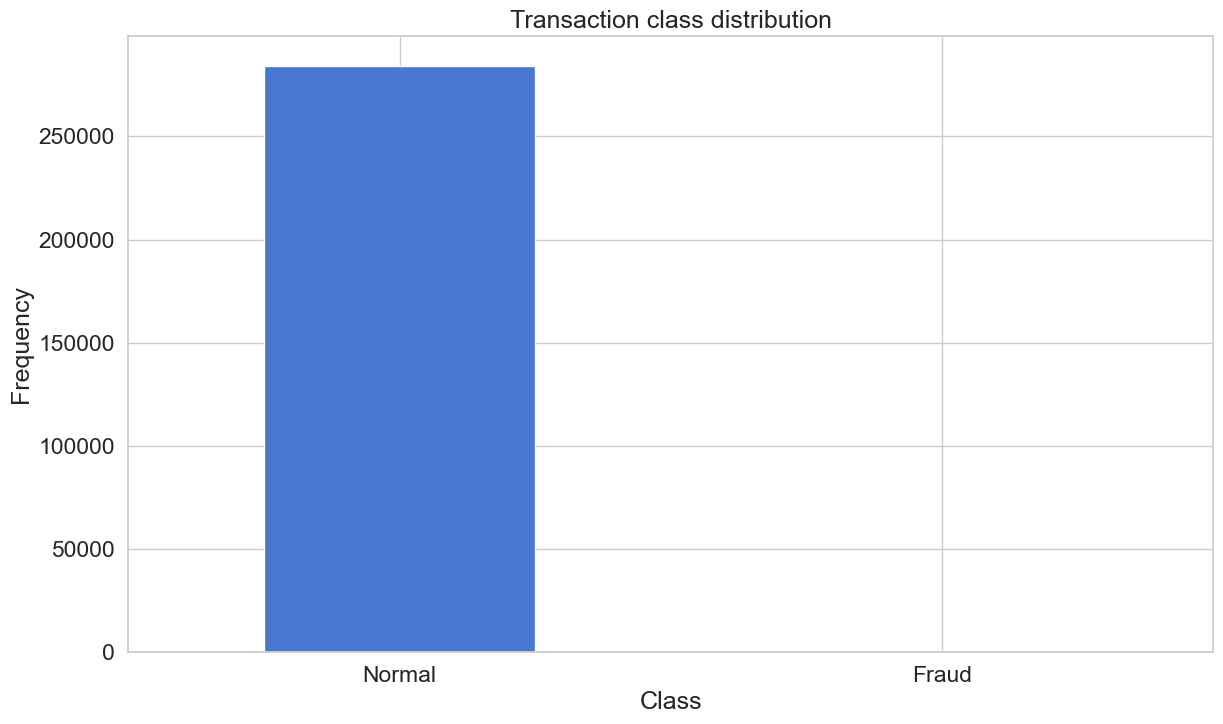

In [11]:
# Visualization
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

We have a highly imbalanced dataset on our hands. Normal transactions overwhelm the fraudulent ones by a large margin. Let's look at the two types of transactions:

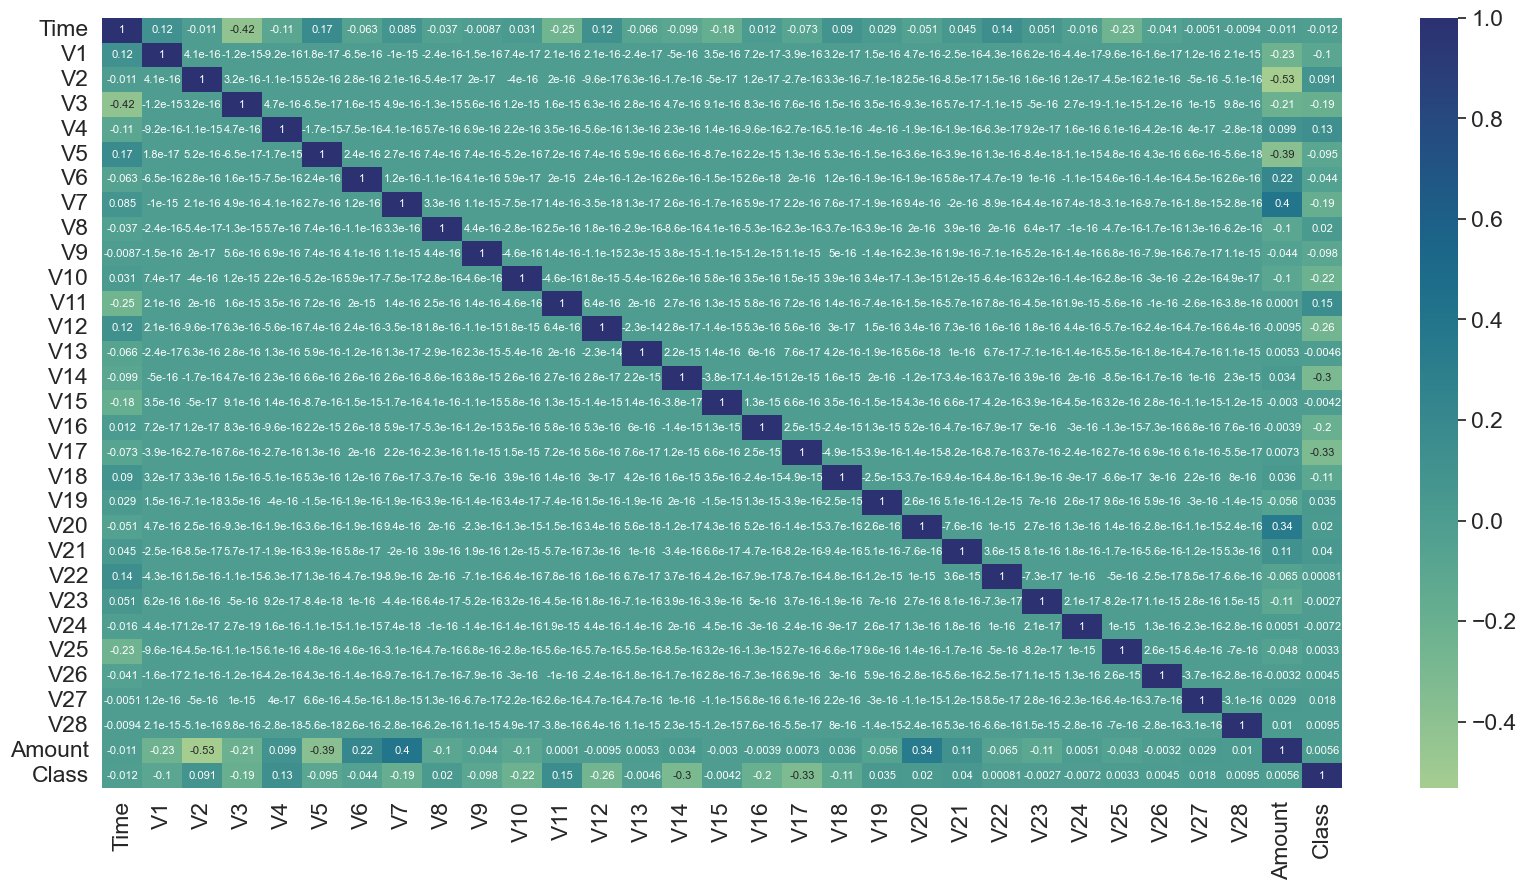

In [12]:
paper = plt.figure(figsize=[20, 10])
sns.heatmap(df.corr(), cmap='crest', annot=True, annot_kws={"size": 8})
plt.show()

In [13]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

print("frauds.shape:", frauds.shape)
print("normal.shape:", normal.shape)

frauds.shape: (492, 31)
normal.shape: (284315, 31)


<h1 style="color:blue;">Data Preprocessing</h1>

Separate features and labels

In [14]:
X = df.drop(['Class'], axis=1)  # 'Class' is the fraud label
y = df['Class']

print("X.shape:", X.shape)
print("y.shape:", y.shape)

X.shape: (284807, 30)
y.shape: (284807,)


### Combine Oversampling the Minority Class + Undersampling the Majority Class

In [15]:
# Combine Oversampling the Minority Class + Undersampling the Majority Class

from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

print("Resampled dataset shape:", X_resampled.shape, y_resampled.value_counts())


Resampled dataset shape: (541135, 30) Class
1    275740
0    265395
Name: count, dtype: int64


* create new dataframe for balanced dataset

In [16]:
# Convert X_resampled and y_resampled into a DataFrame
X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)  # Use the original column names for X
y_resampled_df = pd.Series(y_resampled, name='Class')          # Name the target column as 'Class'

# Combine X_resampled and y_resampled into a single DataFrame
df_resampled = pd.concat([X_resampled_df, y_resampled_df], axis=1)

# Preview the resampled DataFrame
print(df_resampled.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [17]:
frauds = df_resampled[df_resampled.Class == 1]
normal = df_resampled[df_resampled.Class == 0]
print("frauds.shape:", frauds.shape)
print("normal.shape:", normal.shape)

frauds.shape: (275740, 31)
normal.shape: (265395, 31)


======================================

<h1 style="color:blue;">Model Training (Hybrid)</h1>

<h2 style="color:blue;">Autoencoder Model</h2>

* Split Data using Blananced Dataset

In [18]:
# Split Data using Blananced Dataset
X = df_resampled.drop('Class', axis=1)
y = df_resampled['Class']

print("frauds.shape:", X.shape)
print("normal.shape:", y.shape)

frauds.shape: (541135, 30)
normal.shape: (541135,)


In [19]:
scaler = StandardScaler()
X[['Time', 'Amount']] = scaler.fit_transform(X_resampled[['Time', 'Amount']])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)
print("y_train.shape:", y_train.shape)
print("y_test.shape:", y_test.shape)

X_train.shape: (432908, 30)
X_test.shape: (108227, 30)
y_train.shape: (432908,)
y_test.shape: (108227,)


* PCA

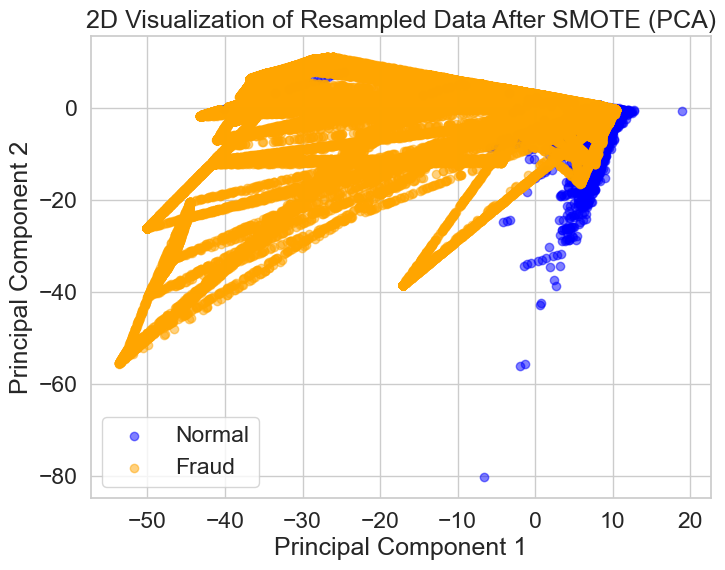

In [21]:
# PCA
from sklearn.decomposition import PCA
import numpy as np

# Reduce dimensionality to 2D for visualization
pca = PCA(n_components=2, random_state=42)
X_train_sm_pca = pca.fit_transform(X_train)

# Create a scatter plot
plt.figure(figsize=(8, 6))
for class_value, color, label in zip([0, 1], ['blue', 'orange'], ['Normal', 'Fraud']):
    plt.scatter(X_train_sm_pca[np.array(y_train) == class_value, 0],
                X_train_sm_pca[np.array(y_train) == class_value, 1],
                alpha=0.5, c=color, label=label)

plt.title('2D Visualization of Resampled Data After SMOTE (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


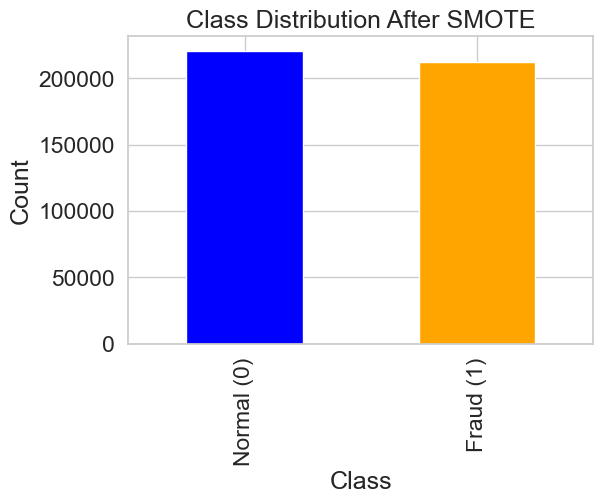

In [22]:
import matplotlib.pyplot as plt

# Visualizing class distribution after SMOTE
y_train.value_counts().plot(kind='bar', color=['blue', 'orange'], figsize=(6, 4))
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Normal (0)', 'Fraud (1)'])
plt.show()

* Unsupervised Learning with Autoencoder for Anomaly Detection

In [23]:
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Create a subset of the data with only normal transactions (Class 0) for training the autoencoder
X_train_autoencoder = X_train[y_train == 0]  # Only normal transactions for training the autoencoder

# Define the autoencoder model

#autoencoder = models.Sequential([
#    layers.Input(shape=(X_train_autoencoder.shape[1],)),  # Input layer
#    layers.Dense(32, activation='relu'),  # Encoder layers
#    layers.Dense(16, activation='relu'),
#    layers.Dense(8, activation='relu'),  # Bottleneck layer (smallest representation)
#    layers.Dense(16, activation='relu'),  # Decoder layers
#    layers.Dense(32, activation='relu'),
#    layers.Dense(X_train_autoencoder.shape[1], activation='sigmoid')  # Output layer
#])

autoencoder = models.Sequential([
    layers.Input(shape=(X_train_autoencoder.shape[1],)),  # Input layer
    layers.Dense(64, activation='relu'),  # Encoder layers
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),  # Bottleneck layer (smallest representation)
    layers.Dense(32, activation='relu'),  # Decoder layers
    layers.Dense(64, activation='relu'),
    layers.Dense(X_train_autoencoder.shape[1], activation='sigmoid')  # Output layer
])


# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()




Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           1,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 30)                  │           1,950 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,198 (35.93 KB)

 Trainable params: 9,198 (35.93 KB)

 Non-trainable params: 0 (0.00 B)

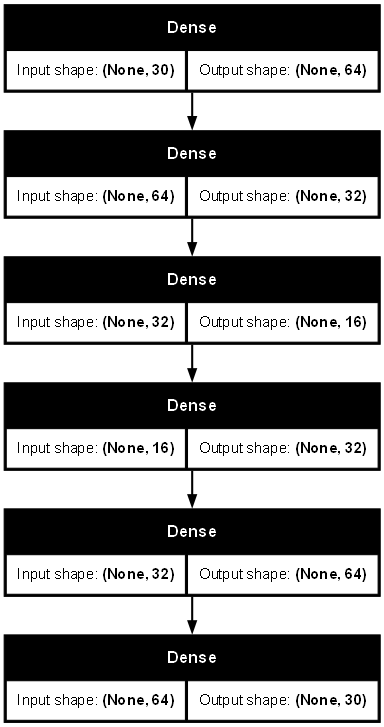

In [24]:
plot_model(autoencoder, 
           show_shapes=True, 
           to_file='autoencoder_model.png', 
           dpi=75)

Epoch 1/50
747/747 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9579 - val_loss: 0.8150
Epoch 2/50
747/747 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7962 - val_loss: 0.7986
Epoch 3/50
747/747 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7858 - val_loss: 0.7914
Epoch 4/50
747/747 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7761 - val_loss: 0.7882
Epoch 5/50
747/747 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8104 - val_loss: 0.7857
Epoch 6/50
747/747 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7856 - val_loss: 0.7814
Epoch 7/50
747/747 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7605 - val_loss: 0.7796
Epoch 8/50
747/747 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7749 - val_loss: 0.7795
Epoch 9/50
747/747 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7942 - val_loss: 0.7786
Epoch 10/50
747/747 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7695 - val_loss: 0.7784
Epoch 11/50
747/747 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7732 - val_loss: 0.7788
Epoch 12/50
747/747 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

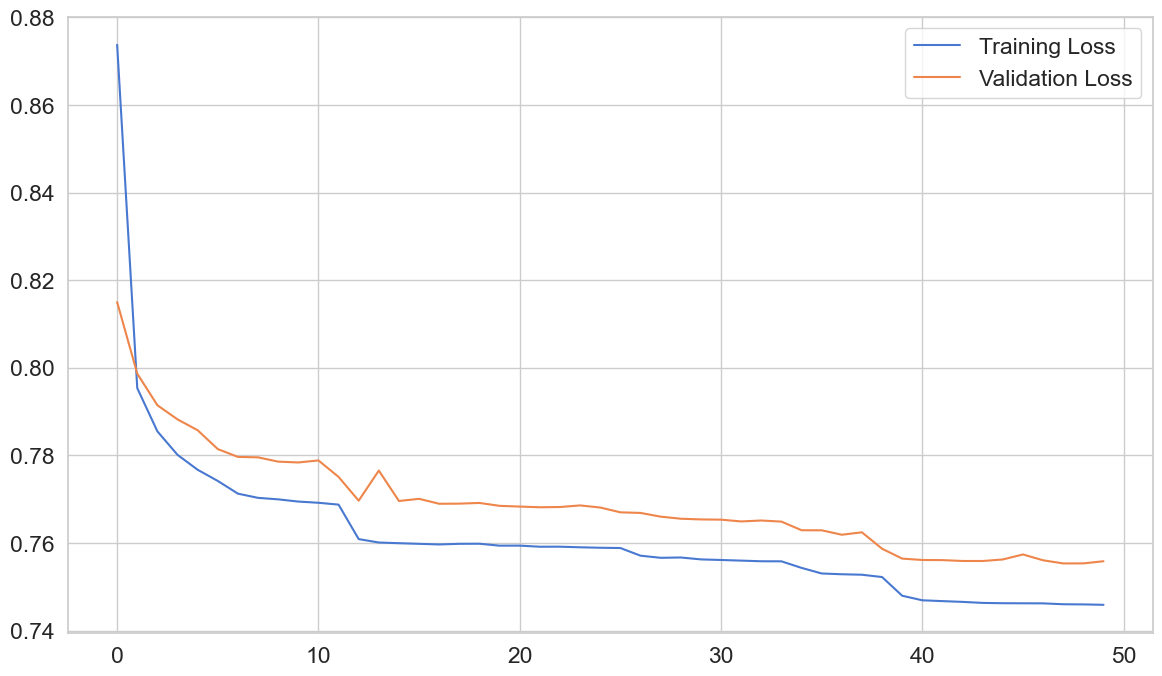

In [25]:
# Train the autoencoder with normal data
history = autoencoder.fit(
    X_train_autoencoder, X_train_autoencoder,
    epochs=50,
    batch_size=256,
    validation_split=0.1,
    shuffle=True
)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [26]:
# 1. Calculate Reconstruction Errors on Training Data

# Calculate reconstruction error for training data
train_reconstructions = autoencoder.predict(X_train_autoencoder)
train_errors = np.mean(np.square(X_train_autoencoder - train_reconstructions), axis=1)

# Set threshold as 95th percentile of reconstruction errors from training data
threshold = np.percentile(train_errors, 95)
print(f"Reconstruction error threshold: {threshold}")


6632/6632 ━━━━━━━━━━━━━━━━━━━━ 4s 531us/step
Reconstruction error threshold: 1.5973551001284032


In [27]:
# 2. Test on Anomalous Data
# Evaluate on test data (both normal and anomalous transactions)
test_reconstructions = autoencoder.predict(X_test)
test_errors = np.mean(np.square(X_test - test_reconstructions), axis=1)

# Classify transactions based on the threshold
test_predictions = (test_errors > threshold).astype(int)  # 1 = anomaly, 0 = normal

# Calculate evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:")
print(confusion_matrix(y_test, test_predictions))

print("\nClassification Report:")
print(classification_report(y_test, test_predictions))


3383/3383 ━━━━━━━━━━━━━━━━━━━━ 1s 404us/step
Confusion Matrix:
[[50547  2642]
 [ 5469 49569]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93     53189
           1       0.95      0.90      0.92     55038

    accuracy                           0.93    108227
   macro avg       0.93      0.93      0.93    108227
weighted avg       0.93      0.93      0.93    108227



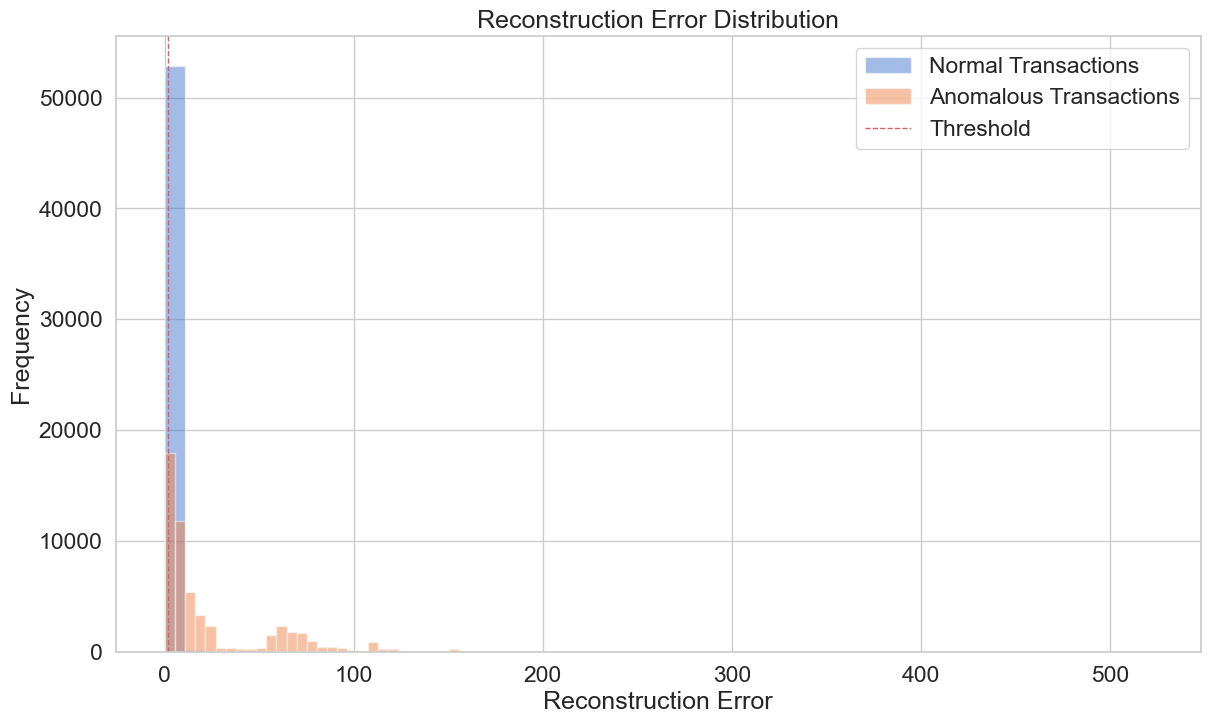

In [28]:
# 3. Visualize Reconstruction Errors
import matplotlib.pyplot as plt

# Plot histogram of reconstruction errors
plt.hist(test_errors[y_test == 0], bins=50, alpha=0.5, label='Normal Transactions')
plt.hist(test_errors[y_test == 1], bins=50, alpha=0.5, label='Anomalous Transactions')
plt.axvline(threshold, color='r', linestyle='dashed', linewidth=1, label='Threshold')
plt.legend()
plt.title("Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.show()


* Exmine reconstruction error

3383/3383 ━━━━━━━━━━━━━━━━━━━━ 2s 533us/step


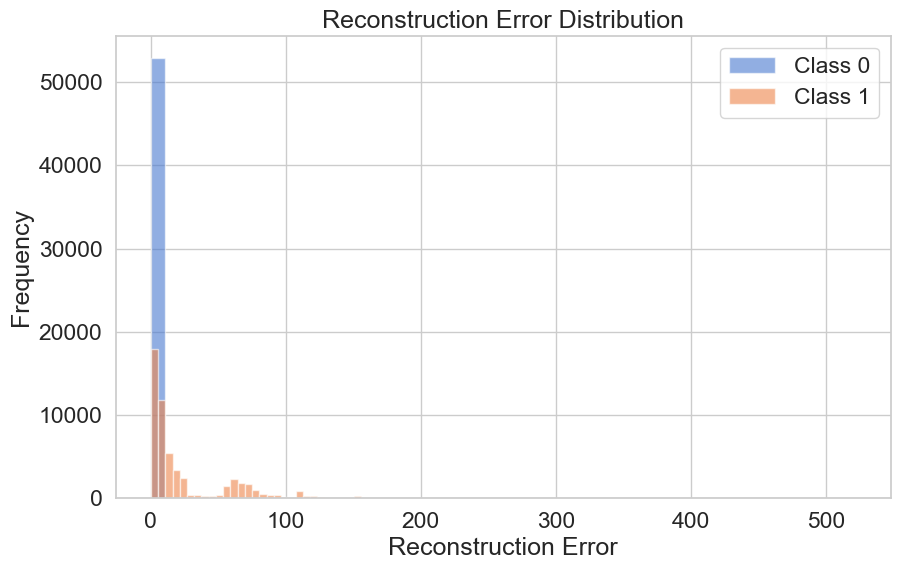

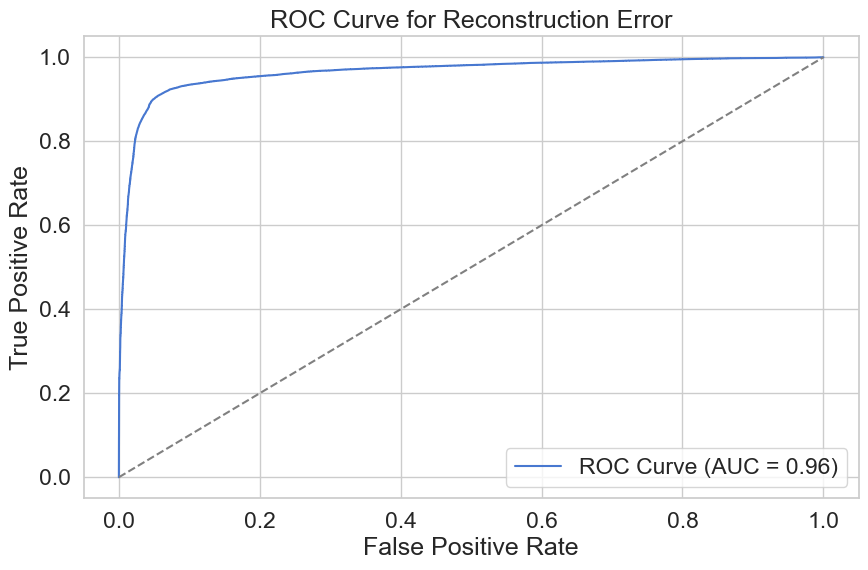

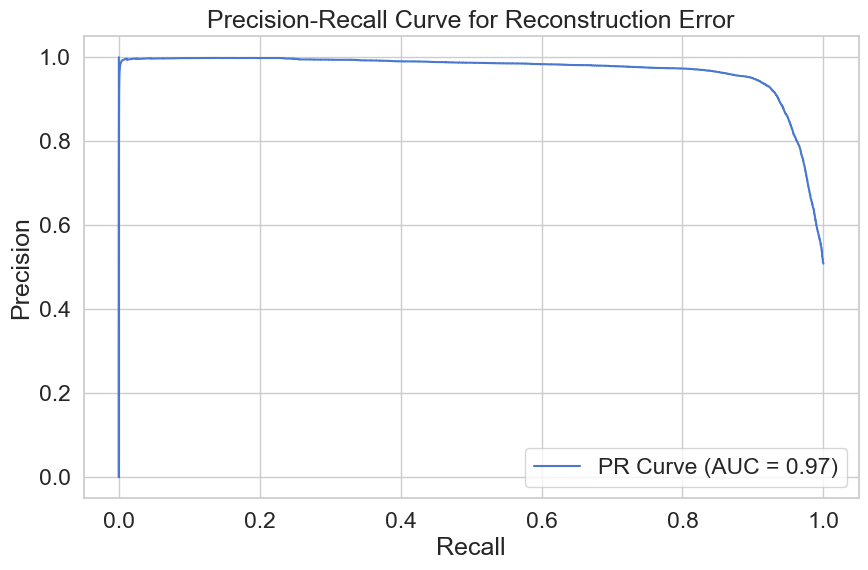

Optimal Threshold for Reconstruction Error: 1.4600627177456005


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc

# Assuming you have the following:
# - `X_train`: Training dataset
# - `X_test`: Test dataset
# - `y_test`: True labels for the test dataset
# - `autoencoder`: Trained autoencoder model

# 1. Generate Reconstruction Errors
# Calculate reconstruction errors for the test set
X_test_reconstructed = autoencoder.predict(X_test)
reconstruction_errors = np.mean(np.square(X_test - X_test_reconstructed), axis=1)

# Add reconstruction errors as a feature for examination
reconstruction_df = pd.DataFrame({
    'reconstruction_error': reconstruction_errors,
    'true_label': y_test
})

# 2. Visualize Reconstruction Errors
plt.figure(figsize=(10, 6))
for label in [0, 1]:  # Assuming 0 = Non-fraud, 1 = Fraud
    subset = reconstruction_df[reconstruction_df['true_label'] == label]
    plt.hist(subset['reconstruction_error'], bins=50, alpha=0.6, label=f"Class {label}")
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 3. Evaluate Threshold Using ROC-AUC
fpr, tpr, thresholds = roc_curve(reconstruction_df['true_label'], reconstruction_df['reconstruction_error'])
roc_auc = roc_auc_score(reconstruction_df['true_label'], reconstruction_df['reconstruction_error'])

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve for Reconstruction Error')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# 4. Precision-Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(reconstruction_df['true_label'], reconstruction_df['reconstruction_error'])
pr_auc = auc(recall, precision)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})')
plt.title('Precision-Recall Curve for Reconstruction Error')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# 5. Choose a Threshold for Reconstruction Errors
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold for Reconstruction Error: {optimal_threshold}")


* Add the reconstruction error as a feature to the balanced dataset

In [30]:
# Generate reconstruction error for all data
X_reconstructed = autoencoder.predict(X)
reconstruction_error = np.mean(np.power(X - X_reconstructed, 2), axis=1)

# Add reconstruction error to the original DataFrame
df_resampled['Autoencoder_Reconstruction_Error'] = reconstruction_error

# Preview the updated DataFrame
print(df_resampled.head())

16911/16911 ━━━━━━━━━━━━━━━━━━━━ 9s 508us/step
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V22       V23       V24       V25       V26  \
0  0.098698  0.363787  ...  0.277838 -0.110474  0.066928  0.128539 -0.189115   
1  0.085102 -0.255425  ... -0.638672  0.101288 -0.339846  0.167170  0.125895   
2  0.247676 -1.514654  ...  0.771679  0.909412 -0.689281 -0.327642 -0.139097   
3  0.377436 -1.387024  ...  0.005274 -0.190321 -1.175575  0.647376 -0.221929   
4 -0.270533  0.817739  ...  0.798278 -0.137458  0.141267 -0.206010

In [31]:
df_resampled.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Autoencoder_Reconstruction_Error
count,541135.000000,541135.000000,541135.000000,541135.000000,541135.000000,541135.000000,541135.000000,541135.000000,541135.000000,541135.000000,...,541135.000000,541135.000000,541135.000000,541135.000000,541135.000000,541135.000000,541135.000000,541135.000000,541135.000000,541135.000000
mean,87654.667480,-2.578460,2.004191,-3.793498,2.402702,-1.701516,-0.744760,-3.054897,0.286053,-1.381086,...,-0.012625,-0.002055,-0.056283,0.025968,0.028830,0.083970,0.042333,94.191156,0.509559,13.428664
std,48196.117297,5.542907,3.680326,6.246222,3.177086,4.204822,1.718660,5.813260,5.082256,2.253648,...,1.187019,1.028863,0.538820,0.616131,0.444977,0.970090,0.419369,222.355631,0.499909,27.548121
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000,0.030104
25%,45509.544915,-3.229890,-0.066128,-5.398087,-0.029066,-1.935301,-1.604235,-3.457506,-0.194034,-2.400667,...,-0.502599,-0.224412,-0.386352,-0.304455,-0.264240,-0.067377,-0.057790,2.990000,0.000000,0.375373
50%,80593.000000,-0.852456,1.067749,-1.640461,1.573821,-0.461490,-0.716510,-0.799411,0.180214,-0.847326,...,0.020317,-0.026232,-0.009500,0.043586,-0.003944,0.062378,0.037884,23.890000,1.000000,1.285801
75%,134767.733205,0.773698,3.024575,0.230282,4.501427,0.421158,0.002228,0.172852,0.890156,0.061613,...,0.525781,0.189876,0.338435,0.366422,0.310015,0.450408,0.219823,99.900000,1.000000,9.913717
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000,1885.680194


==================================================================================

<h2 style="color:blue;">K-Means Model</h2>

* Split Data using Blananced Dataset

In [32]:
# Step 2: Select feature columns (excluding target and Autoencoder reconstruction error)
features = df_resampled.drop(columns=['Class', 'Autoencoder_Reconstruction_Error'], axis=1)

In [33]:
features.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,541135.000000,541135.000000,541135.000000,541135.000000,541135.000000,541135.000000,541135.000000,541135.000000,541135.000000,541135.000000,...,541135.000000,541135.000000,541135.000000,541135.000000,541135.000000,541135.000000,541135.000000,541135.000000,541135.000000,541135.000000
mean,87654.667480,-2.578460,2.004191,-3.793498,2.402702,-1.701516,-0.744760,-3.054897,0.286053,-1.381086,...,0.191813,0.413220,-0.012625,-0.002055,-0.056283,0.025968,0.028830,0.083970,0.042333,94.191156
std,48196.117297,5.542907,3.680326,6.246222,3.177086,4.204822,1.718660,5.813260,5.082256,2.253648,...,1.045522,2.926743,1.187019,1.028863,0.538820,0.616131,0.444977,0.970090,0.419369,222.355631
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-54.497720,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000
25%,45509.544915,-3.229890,-0.066128,-5.398087,-0.029066,-1.935301,-1.604235,-3.457506,-0.194034,-2.400667,...,-0.187790,-0.157108,-0.502599,-0.224412,-0.386352,-0.304455,-0.264240,-0.067377,-0.057790,2.990000
50%,80593.000000,-0.852456,1.067749,-1.640461,1.573821,-0.461490,-0.716510,-0.799411,0.180214,-0.847326,...,0.041936,0.170068,0.020317,-0.026232,-0.009500,0.043586,-0.003944,0.062378,0.037884,23.890000
75%,134767.733205,0.773698,3.024575,0.230282,4.501427,0.421158,0.002228,0.172852,0.890156,0.061613,...,0.447394,0.675143,0.525781,0.189876,0.338435,0.366422,0.310015,0.450408,0.219823,99.900000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,39.420904,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000


In [34]:
# Standardize the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

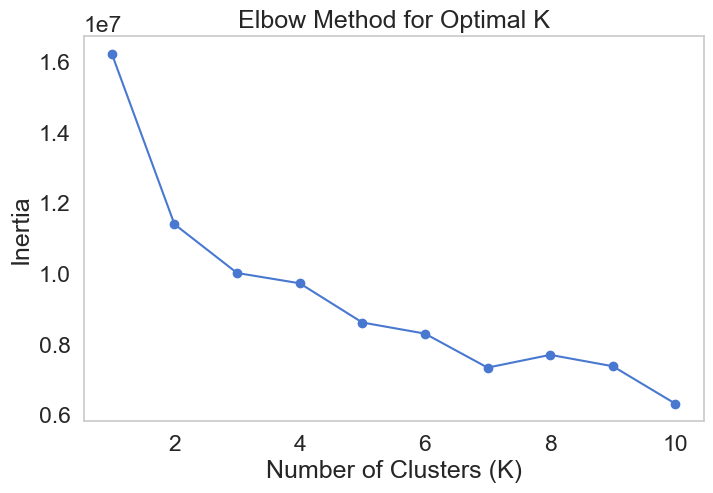

In [35]:
# Step 3: Apply K-Means clustering
# Determine the optimal number of clusters using the Elbow Method
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.grid()
plt.show()

In [36]:
# Step 4: Compute K-Means reconstruction error (distance from cluster center)
# Reconstruction error is calculated as the squared Euclidean distance from the cluster center
kmeans_reconstruction_error = np.min(kmeans.transform(features_scaled), axis=1)

In [37]:
# Step 5: Add K-Means reconstruction error to the dataset
df_resampled['KMeans_Reconstruction_Error'] = kmeans_reconstruction_error

In [38]:
# Step 6: Display the updated dataset
print("\nUpdated Dataset with K-Means Reconstruction Error:")
print(df_resampled.head())


Updated Dataset with K-Means Reconstruction Error:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V23       V24       V25       V26       V27  \
0  0.098698  0.363787  ... -0.110474  0.066928  0.128539 -0.189115  0.133558   
1  0.085102 -0.255425  ...  0.101288 -0.339846  0.167170  0.125895 -0.008983   
2  0.247676 -1.514654  ...  0.909412 -0.689281 -0.327642 -0.139097 -0.055353   
3  0.377436 -1.387024  ... -0.190321 -1.175575  0.647376 -0.221929  0.062723   
4 -0.270533  0.817739  ... -0.137458  0.141267 -0.206010  0.5

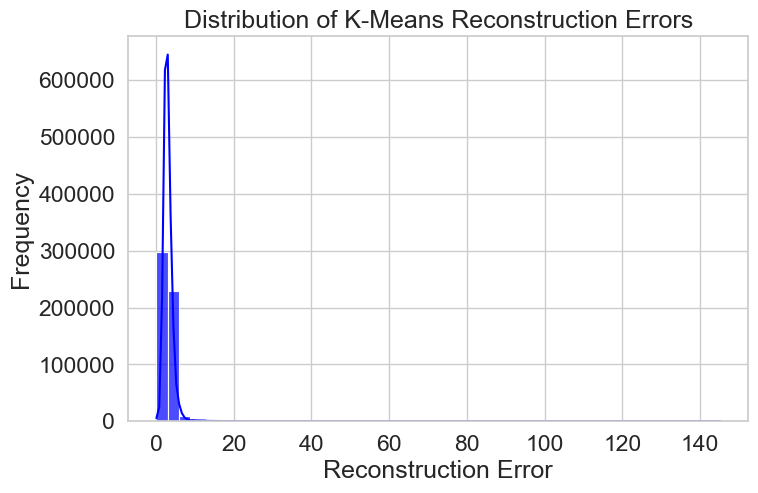

In [39]:
# Plot the distribution of K-Means reconstruction errors
plt.figure(figsize=(8, 5))
sns.histplot(df_resampled['KMeans_Reconstruction_Error'], kde=True, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of K-Means Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()

=======================================================================

<h2 style="color:blue;">CNN Model</h2>

In [40]:
# Step 3: Prepare the dataset for CNN
# Select features (including reconstruction errors) and labels
X = df_resampled.drop(columns=['Class'], axis=1)  # Features
y = df_resampled['Class']  # Labels

In [41]:
# Standardize the feature values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [42]:
# Reshape features for CNN (CNN expects input in 3D: [samples, timesteps, features])
# Here, timesteps = 1 since we have a single-dimensional feature space
X_cnn = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

In [43]:
# Step 4: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_cnn, y, test_size=0.2, random_state=42)

In [44]:
# Step 5: Build the CNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout

model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

C:\Installed\Python_3.12\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 30, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 28, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1792)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         229,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 235,969 (921.75 KB)

 Trainable params: 235,969 (921.75 KB)

 Non-trainable params: 0 (0.00 B)

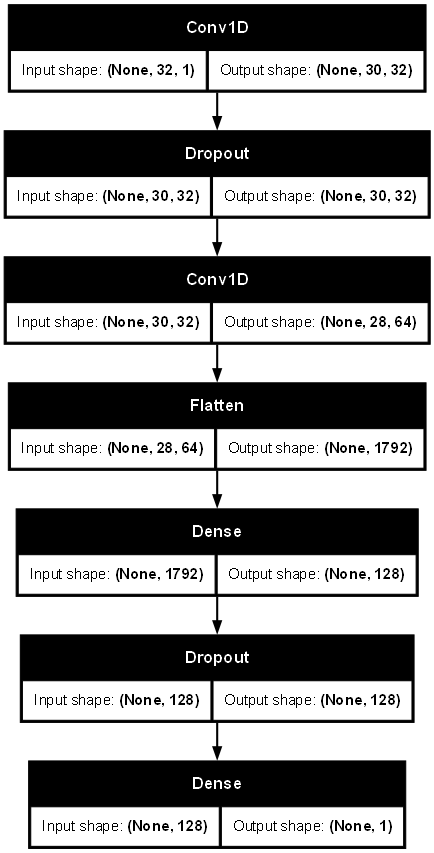

In [45]:
plot_model(model, 
           show_shapes=True, 
           to_file='cnn_model.png', 
           dpi=75)

In [46]:
# Step 6: Train the CNN model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/20
10823/10823 ━━━━━━━━━━━━━━━━━━━━ 88s 8ms/step - accuracy: 0.9812 - loss: 0.0541 - val_accuracy: 0.9978 - val_loss: 0.0082
Epoch 2/20
10823/10823 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.9964 - loss: 0.0114 - val_accuracy: 0.9985 - val_loss: 0.0045
Epoch 3/20
10823/10823 ━━━━━━━━━━━━━━━━━━━━ 84s 8ms/step - accuracy: 0.9979 - loss: 0.0069 - val_accuracy: 0.9993 - val_loss: 0.0030
Epoch 4/20
10823/10823 ━━━━━━━━━━━━━━━━━━━━ 84s 8ms/step - accuracy: 0.9985 - loss: 0.0055 - val_accuracy: 0.9992 - val_loss: 0.0026
Epoch 5/20
10823/10823 ━━━━━━━━━━━━━━━━━━━━ 86s 8ms/step - accuracy: 0.9987 - loss: 0.0049 - val_accuracy: 0.9996 - val_loss: 0.0018
Epoch 6/20
10823/10823 ━━━━━━━━━━━━━━━━━━━━ 81s 7ms/step - accuracy: 0.9990 - loss: 0.0034 - val_accuracy: 0.9996 - val_loss: 0.0024
Epoch 7/20
10823/10823 ━━━━━━━━━━━━━━━━━━━━ 63s 6ms/step - accuracy: 0.9990 - loss: 0.0035 - val_accuracy: 0.9994 - val_loss: 0.0039
Epoch 8/20
10823/10823 ━━━━━━━━━━━━━━━━━━━━ 58s 5ms/step - accuracy: 

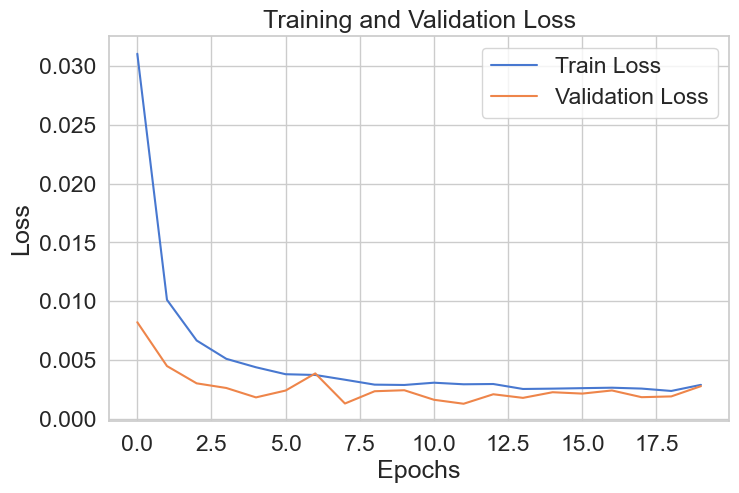

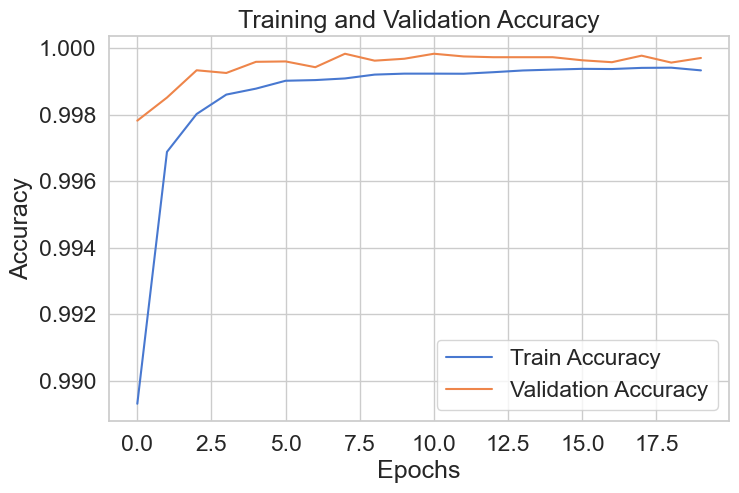

In [52]:
# Step 9: Plot Training and Validation Loss
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step 10: Plot Training and Validation Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [48]:
# Step 7: Evaluate the model
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

Test Accuracy: 1.00


In [49]:
# Step 8: Generate predictions and classification report
y_pred = (model.predict(X_test) > 0.5).astype(int)

3383/3383 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


In [50]:
# Confusion Matrix and Classification Report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[53150    39]
 [    0 55038]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53189
           1       1.00      1.00      1.00     55038

    accuracy                           1.00    108227
   macro avg       1.00      1.00      1.00    108227
weighted avg       1.00      1.00      1.00    108227



3383/3383 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


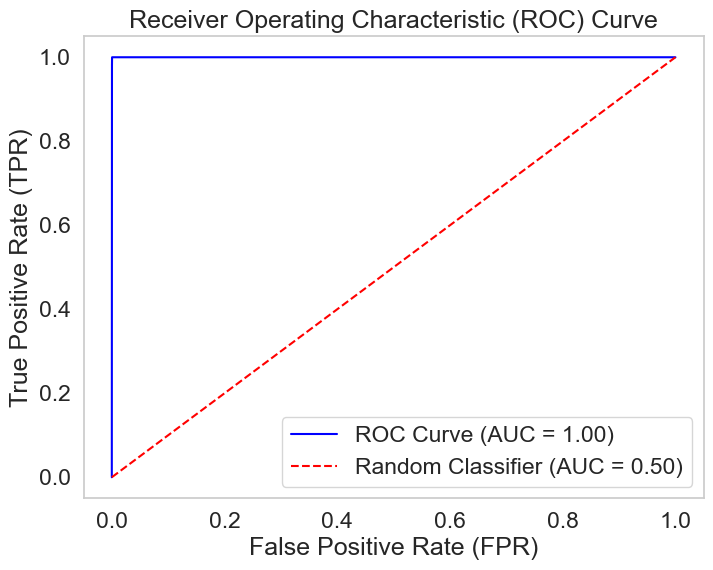

In [51]:
# ROC Curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Step 8: Generate predictions (probabilities) for ROC Curve
y_pred_prob = model.predict(X_test)  # Predict probabilities instead of binary labels

# Calculate the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)  # Calculate Area Under the Curve (AUC)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier (AUC = 0.50)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid()
plt.show()
